In [16]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.feature import hog
from skimage import feature
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import joblib
import json
import random

from pathlib import Path

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import glob

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize

from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
from torchvision.transforms import ToPILImage

import matplotlib.pyplot as plt
%matplotlib inline

# importing malaria dataset class to map bounding boxes on one image
# and skipping any null values with detection collate
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from malaria_dataset import MalariaDataset, detection_collate

In [3]:
# Paths
root_path = os.path.join('..', 'dataset', 'malaria')
train_base_path = os.path.join(root_path, 'training_ds')
test_base_path = os.path.join(root_path, 'testing_ds')
image_path = os.path.join(root_path, 'images')
train_json_path = os.path.join(root_path, 'training.json')
test_json_path = os.path.join(root_path, 'test.json')

FEATURES_DIR = os.path.join(root_path, 'extracted_features')
os.makedirs(FEATURES_DIR, exist_ok=True)

# --- Create a directory to store the trained models ---
MODELS_DIR = os.path.join('.', 'trained_models')
os.makedirs(MODELS_DIR, exist_ok=True)


image_sizes = [128]
print("Root Path:", root_path)
print("Train Base Path:", train_base_path)
print("Test Base Path:", test_base_path)

Root Path: ..\dataset\malaria
Train Base Path: ..\dataset\malaria\training_ds
Test Base Path: ..\dataset\malaria\testing_ds


### Model Training

In [4]:
experiment_results = []
feature_files = glob.glob(os.path.join(FEATURES_DIR, "*.pkl"))

if not feature_files:
    print("ERROR: No feature files found!")
    print(f"Please run the Feature Extraction cell first to create .pkl files in: {FEATURES_DIR}")

# --- Main Training Loop ---
for file_path in feature_files:
    filename = os.path.basename(file_path)
    # Correctly unpack filename assuming format "size_extractorName_features.pkl"
    size, extractor_name, _ = filename.split('_', 2)
    
    print(f"\n{'='*25}")
    print(f"RUNNING EXPERIMENT")
    print(f"Image Size: {size}x{size} | Feature Extractor: {extractor_name}")
    print(f"{'='*25}")
    
    # --- 1. Load Pre-computed Feature Data ---
    data = joblib.load(file_path)
    X_train, y_train = data['X_train'], data['y_train']
    X_test, y_test = data['X_test'], data['y_test']
    le = data['label_encoder']
    
    # --- 2. Build, Train, or Load the Pipeline ---
    # MODIFIED: Changed model name in path to 'rf_model' for clarity
    model_path = os.path.join(MODELS_DIR, f"{size}_{extractor_name}_rf_model.pkl")

    # --- Check if the model is already trained ---
    if os.path.exists(model_path):
        print(f"Loading pre-trained model from: {model_path}")
        pipeline = joblib.load(model_path)
    else:
        # If model not found, define the pipeline and train it
        print("Pre-trained model not found. Training a new model...")
        
        # --- MODIFICATION START ---
        # Replaced the SVM pipeline with a RandomForest pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Scaling is less critical for RF but kept for consistency
            ('smote', SMOTE(random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)) # Using RandomForest
        ])
        # --- MODIFICATION END ---
        
        pipeline.fit(X_train, y_train) # This is the training line
        
        # --- Save the newly trained pipeline ---
        print(f"Saving trained model to: {model_path}")
        joblib.dump(pipeline, model_path)

    # --- 3. Evaluation ---
    print("\n--- Evaluation Results ---")
    predictions = pipeline.predict(X_test)
    report = classification_report(y_test, predictions, target_names=le.classes_, output_dict=True)
    print(classification_report(y_test, predictions, target_names=le.classes_))

    # --- 4. Store Results for Final Summary ---
    experiment_results.append({
        'image_size': size,
        'feature_extractor': extractor_name,
        'accuracy': report['accuracy'],
        'f1_score_weighted': report['weighted avg']['f1-score']
    })

# --- 5. Display Final Summary Table ---
if experiment_results:
    print(f"\n{'='*30}")
    print("FINAL EXPERIMENT SUMMARY")
    print(f"{'='*30}")
    results_df = pd.DataFrame(experiment_results)
    results_df = results_df.sort_values(by='f1_score_weighted', ascending=False)
    display(results_df)
    
    summary_path = 'model_experiment_summary.csv'
    results_df.to_csv(summary_path, index=False)
    print(f"\nSummary saved to {summary_path}")


RUNNING EXPERIMENT
Image Size: 128x128 | Feature Extractor: HIST
Loading pre-trained model from: .\trained_models\128_HIST_rf_model.pkl

--- Evaluation Results ---
                precision    recall  f1-score   support

     difficult       0.17      0.06      0.09        16
    gametocyte       0.00      0.00      0.00        14
     leukocyte       1.00      0.81      0.89        21
red_blood_cell       0.96      1.00      0.98      6869
          ring       1.00      0.01      0.01       173
      schizont       0.00      0.00      0.00        12
   trophozoite       0.77      0.32      0.45       168

      accuracy                           0.95      7273
     macro avg       0.56      0.31      0.35      7273
  weighted avg       0.95      0.95      0.94      7273


RUNNING EXPERIMENT
Image Size: 128x128 | Feature Extractor: HOG


c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

Loading pre-trained model from: .\trained_models\128_HOG_rf_model.pkl

--- Evaluation Results ---


c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

                precision    recall  f1-score   support

     difficult       0.00      0.00      0.00        16
    gametocyte       0.00      0.00      0.00        14
     leukocyte       0.82      0.43      0.56        21
red_blood_cell       0.95      1.00      0.97      6869
          ring       0.00      0.00      0.00       173
      schizont       0.00      0.00      0.00        12
   trophozoite       0.58      0.11      0.19       168

      accuracy                           0.95      7273
     macro avg       0.33      0.22      0.25      7273
  weighted avg       0.91      0.95      0.92      7273


RUNNING EXPERIMENT
Image Size: 128x128 | Feature Extractor: LBP
Loading pre-trained model from: .\trained_models\128_LBP_rf_model.pkl

--- Evaluation Results ---
                precision    recall  f1-score   support

     difficult       0.00      0.06      0.01        16
    gametocyte       0.04      0.14      0.07        14
     leukocyte       0.38      0.38      0.38    

,image_size,feature_extractor,accuracy,f1_score_weighted
0,128,HIST,0.953664,0.936408
1,128,HOG,0.946240,0.924316
2,128,LBP,0.875430,0.903663



Summary saved to model_experiment_summary.csv


## Model Loading

In [18]:
# ==============================================================================
# STEP 1: LOAD YOUR TRAINED MODEL AND GROUND TRUTH DATA
# ==============================================================================
print("STEP 1: Loading model and preparing ground truth data...")

# --- Configuration ---
# MODEL_PATH = r'C:\Users\shera\Desktop\fyp\fyp\random_forest_model\trained_models\128_HIST_rf_model.pkl'
MODEL_PATH = os.path.join(MODELS_DIR, '128_HIST_rf_model.pkl')

CLASS_MAP = {
    0: 'difficult', 1: 'gametocyte', 2: 'leukocyte', 3: 'red blood cell',
    4: 'ring', 5: 'schizont', 6: 'trophozoite'
}
NEGATIVE_CLASSES = {'red blood cell', 'leukocyte', 'difficult'}

# --- Load Model ---
try:
    pipeline = joblib.load(MODEL_PATH)
    model = pipeline.named_steps['rf']
    scaler = pipeline.named_steps['scaler']
    print("Model pipeline loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    model, scaler = None, None

# --- Load Ground Truth Data ---
def create_ground_truth_map(json_paths):
    """Loads annotations from JSON files and maps filenames to their objects."""
    gt_map = {}
    for json_path in json_paths:
        try:
            with open(json_path, 'r') as f:
                metadata = json.load(f)
            for item in metadata:
                # Use just the filename as the key
                filename = os.path.basename(item['image']['pathname'])
                gt_map[filename] = item.get('objects', [])
        except FileNotFoundError:
            print(f"Warning: JSON file not found at {json_path}. Skipping.")
    print(f"Ground truth map created with {len(gt_map)} entries.")
ground_truth_map = create_ground_truth_map([train_json_path, test_json_path])
print("-" * 50)



STEP 1: Loading model and preparing ground truth data...
Model pipeline loaded successfully.
Ground truth map created with 1328 entries.
--------------------------------------------------


In [19]:

# ==============================================================================
# STEP 2: HELPER FUNCTIONS (No Changes Needed)
# ==============================================================================
print("STEP 2: Defining helper functions (sliding window, feature extraction, NMS)...")

def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def extract_hist_features(image_patch):
    hist = cv2.calcHist([image_patch], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def non_max_suppression(boxes, scores, overlapThresh):
    if len(boxes) == 0: return []
    boxes, pick = np.array(boxes, dtype="float"), []
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)
    while len(idxs) > 0:
        last, i = len(idxs) - 1, idxs[last]
        pick.append(i)
        xx1,yy1 = np.maximum(x1[i],x1[idxs[:last]]),np.maximum(y1[i],y1[idxs[:last]])
        xx2,yy2 = np.minimum(x2[i],x2[idxs[:last]]),np.minimum(y2[i],y2[idxs[:last]])
        w,h = np.maximum(0,xx2-xx1+1), np.maximum(0,yy2-yy1+1)
        overlap = (w*h) / area[idxs[:last]]
        idxs = np.delete(idxs,np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
    return pick

print("Helper functions are ready.")
print("-" * 50)


STEP 2: Defining helper functions (sliding window, feature extraction, NMS)...
Helper functions are ready.
--------------------------------------------------


In [20]:
print("STEP 3: Defining the final comparison function...")

def compare_prediction_to_ground_truth(
    image_path, model, scaler, class_map, ground_truth_map,
    window_size=(128, 128), step_size=32,
    confidence_threshold=0.7, nms_threshold=0.2
):
    if model is None or scaler is None: return

    # --- 1. Perform Sliding Window Detection (as before) ---
    image = cv2.imread(image_path)
    detections, scores = [], []
    print("Scanning image...")
    for (x, y, window) in tqdm(sliding_window(image, step_size, window_size)):
        if window.shape[0]!=window_size[1] or window.shape[1]!=window_size[0]: continue
        features = extract_hist_features(window)
        scaled_features = scaler.transform(features.reshape(1, -1))
        prediction_proba = model.predict_proba(scaled_features)[0]
        pred_idx = np.argmax(prediction_proba)
        max_conf = prediction_proba[pred_idx]
        pred_name = class_map.get(pred_idx, "Unknown")
        if pred_name not in NEGATIVE_CLASSES and max_conf > confidence_threshold:
            box = [x, y, x + window_size[0], y + window_size[1]]
            detections.append({"box": box, "label": pred_name, "confidence": float(max_conf)})
            scores.append(float(max_conf))

    # Apply NMS
    final_indices = non_max_suppression([d['box'] for d in detections], scores, nms_threshold)
    final_detections = [detections[i] for i in final_indices]
    print(f"Found {len(final_detections)} final objects.")

    # --- 2. Prepare Images for Plotting ---
    original_pil = Image.open(image_path).convert("RGB")
    prediction_pil = original_pil.copy()
    
    # --- 3. Draw Ground Truth and Predictions ---
    draw_gt = ImageDraw.Draw(original_pil)
    draw_pred = ImageDraw.Draw(prediction_pil)
    try: font = ImageFont.truetype("arial.ttf", 20)
    except IOError: font = ImageFont.load_default()

    # Draw Ground Truth Boxes (LIME GREEN)
    filename = os.path.basename(image_path)
    gt_objects = ground_truth_map.get(filename, [])
    for obj in gt_objects:
        if obj['category'] not in NEGATIVE_CLASSES:
            bb = obj['bounding_box']
            box = [bb['minimum']['c'], bb['minimum']['r'], bb['maximum']['c'], bb['maximum']['r']]
            draw_gt.rectangle(box, outline="lime", width=3)
            draw_gt.text((box[0], box[1] - 25), obj['category'], fill="lime", font=font)

    # Draw Predicted Boxes (RED)
    for det in final_detections:
        box = det['box']
        label = f"{det['label']}: {det['confidence']:.2f}"
        draw_pred.rectangle(box, outline="red", width=3)
        draw_pred.text((box[0], box[1] - 25), label, fill="red", font=font)

    # --- 4. Display Side-by-Side ---
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))
    axes[0].imshow(original_pil)
    axes[0].set_title("Ground Truth (Actual Labels)", fontsize=20)
    axes[0].axis('off')
    axes[1].imshow(prediction_pil)
    axes[1].set_title("Model Predictions", fontsize=20)
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()


STEP 3: Defining the final comparison function...


In [21]:
my_image_to_compare = r"C:\Users\shera\Desktop\fyp\fyp\dataset\malaria\images\fe1ee954-ba71-47b3-954a-d20ab940cd7b.png"

# 2. Run the comparison function
compare_prediction_to_ground_truth(
    image_path=my_image_to_compare,
    model=model,
    scaler=scaler,
    class_map=CLASS_MAP,
    ground_truth_map=ground_truth_map,
    window_size=(128, 128)
)

Scanning image...


1564it [01:09, 22.50it/s]


Found 0 final objects.


AttributeError: 'NoneType' object has no attribute 'get'

STEP 1: Loading the pre-trained model and its components...
Model pipeline loaded successfully.
--------------------------------------------------
STEP 2: Defining the final detection function...
Found 98 potential cell candidates.
Classifying candidates...


100%|██████████| 98/98 [00:02<00:00, 42.78it/s]



Found 0 malaria-positive cells.


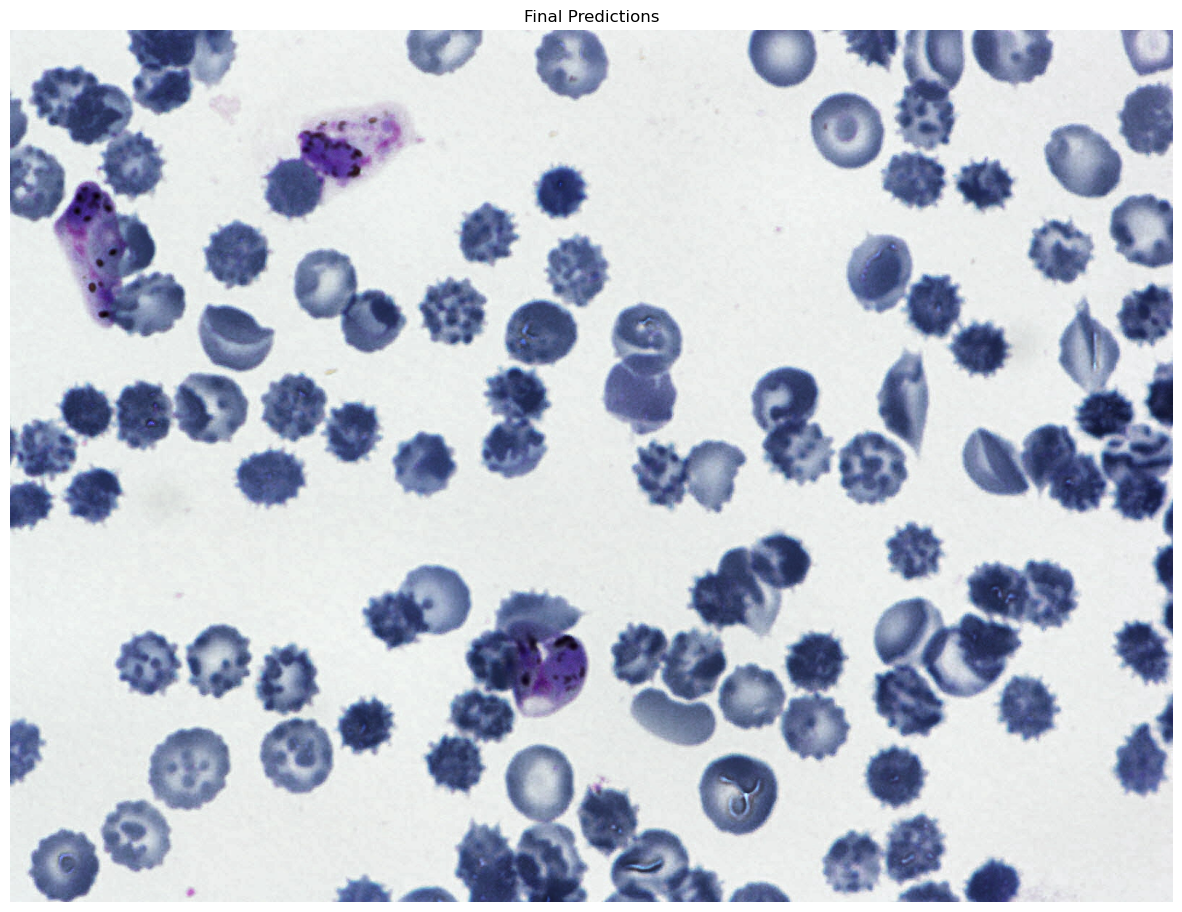

In [30]:
import cv2
import numpy as np
import joblib
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==============================================================================
# STEP 1: LOAD YOUR TRAINED MODEL
# ==============================================================================
print("STEP 1: Loading the pre-trained model and its components...")

MODEL_PATH = r'C:\Users\shera\Desktop\fyp\fyp\random_forest_model\trained_models\128_HIST_rf_model.pkl'

# This class map MUST match the one used for training.
CLASS_MAP = {
    0: 'difficult', 1: 'gametocyte', 2: 'leukocyte', 3: 'red blood cell',
    4: 'ring', 5: 'schizont', 6: 'trophozoite'
}
# We will only draw boxes for these positive classes.
POSITIVE_CLASSES = {'gametocyte', 'ring', 'schizont', 'trophozoite'}

try:
    pipeline = joblib.load(MODEL_PATH)
    model = pipeline.named_steps['rf']
    scaler = pipeline.named_steps['scaler']
    print("Model pipeline loaded successfully.")
except Exception as e:
    print(f"FATAL ERROR: Could not load model. Please check the path.\nDetails: {e}")
    model, scaler = None, None
print("-" * 50)

# ==============================================================================
# STEP 2: THE "FIND-THEN-CLASSIFY" FUNCTION
# ==============================================================================
print("STEP 2: Defining the final detection function...")

def extract_hist_features(image_patch):
    """Extracts features exactly as done in training."""
    hist = cv2.calcHist([image_patch], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def find_and_classify_cells(
    image_path, model, scaler, class_map, 
    min_cell_size=1500, max_cell_size=15000,
    confidence_threshold=0.6
):
    """
    Finds potential cell candidates using contour detection and classifies them.
    """
    if model is None: return

    # --- 1. Find Candidate Cells using Image Processing ---
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image at {image_path}")
        return

    # Convert to HSV color space, which is great for color-based segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define a color range for the cells (these values often work well for Giemsa stains)
    lower_bound = np.array([100, 50, 50])
    upper_bound = np.array([170, 255, 255])
    
    # Create a mask to isolate the purple/blue cell-like objects
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    
    # Find contours (the outlines of the blobs) in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    print(f"Found {len(contours)} potential cell candidates.")

    # --- 2. Classify Each Candidate ---
    final_detections = []
    original_pil = Image.open(image_path).convert("RGB")

    print("Classifying candidates...")
    for cnt in tqdm(contours):
        # Filter out tiny or huge blobs
        if not (min_cell_size < cv2.contourArea(cnt) < max_cell_size):
            continue
            
        # Get the bounding box for the contour
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Crop the candidate from the original image
        cropped_cell = image[y:y+h, x:x+w]
        
        # --- Crucial Step: Resize to match training data ---
        resized_crop = cv2.resize(cropped_cell, (128, 128))
        
        # Extract features and classify
        features = extract_hist_features(resized_crop)
        scaled_features = scaler.transform(features.reshape(1, -1))
        
        prediction_proba = model.predict_proba(scaled_features)[0]
        pred_idx = np.argmax(prediction_proba)
        max_conf = prediction_proba[pred_idx]
        pred_name = class_map.get(pred_idx, "Unknown")
        
        # If it's a confident, positive detection, save it
        if pred_name in POSITIVE_CLASSES and max_conf > confidence_threshold:
            final_detections.append({
                "box": [x, y, x + w, y + h],
                "label": pred_name,
                "confidence": float(max_conf)
            })

    # --- 3. Draw and Display Final Results ---
    print(f"\nFound {len(final_detections)} malaria-positive cells.")
    draw = ImageDraw.Draw(original_pil)
    try: font = ImageFont.truetype("arial.ttf", 20)
    except IOError: font = ImageFont.load_default()
        
    for det in final_detections:
        box = det['box']
        label = f"{det['label']}: {det['confidence']:.2f}"
        draw.rectangle(box, outline="red", width=3)
        draw.text((box[0], box[1] - 25), label, fill="red", font=font)
        
    plt.figure(figsize=(15, 15))
    plt.imshow(original_pil)
    plt.title("Final Predictions")
    plt.axis('off')
    plt.show()

# ==============================================================================
# STEP 3: RUN THE ANALYSIS
# ==============================================================================
IMAGE_TO_TEST = r"C:\Users\shera\Desktop\fyp\fyp\dataset\malaria\images\ff3b9d4d-373c-48ef-a75a-d23e2c2ade87.png"

# --- TUNE THESE PARAMETERS ---
# This is the most important parameter to adjust.
CONFIDENCE = 0.6 

find_and_classify_cells(
    image_path=IMAGE_TO_TEST,
    model=model,
    scaler=scaler,
    class_map=CLASS_MAP,
    confidence_threshold=CONFIDENCE
)